<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/tapi-logo-small.png" />

This notebook free for educational reuse under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/).

Created by [Xanda Schofield](https://www.cs.hmc.edu/~xanda) for the 2022 Text Analysis Pedagogy Institute, with support from the [National Endowment for the Humanities](https://neh.gov), [JSTOR Labs](https://labs.jstor.org/), and [University of Arizona Libraries](https://new.library.arizona.edu/).

For questions/comments/improvements, email xanda@cs.hmc.edu.<br />
____

# Text Data Curation 3

This is lesson 3 of 3 in the educational series on Text Data Curation. This notebook is intended to look at how trained models, such as naive Bayes models and topic models, can actually help the text curation process. 

**Audience:** `Learners` / `Researchers`

**Use case:** [`How-To`](https://constellate.org/docs/documentation-categories#howtoproblemoriented) 

**Difficulty:** `Intermediate`
Assumes users are familiar with Python and have been programming for 6+ months. Code makes up a larger part of the notebook and basic concepts related to Python are not explained.

**Completion time:** `90 minutes`

**Knowledge Required:** 
```
* Python basics (variables, flow control, functions, lists, dictionaries)
* How Python libraries work (installation and imports)
```

**Knowledge Recommended:**
```
* Basic file operations (open, close, read, write)
* How text is stored on computers
```

**Learning Objectives:**
After this lesson, learners will be able to:
```
1. Describe and implement an XXXX for XXXX
2. Convert XXXX into XXXX for the purpose of XXXX
3. Develop a workflow in order to XXXX
4. Be familiar with XXXXX resources for pursuing the topic
```
**Research Pipeline:**
```
1. Research steps before this notebook
2. **The skills in this notebook**
3. Steps after this notebook
4. Final steps
```
___

# Required Python Libraries
`List out any libraries used and what they are used for`
* [Tesseract](https://tesseract-ocr.github.io/) for performing [optical character recognition](https://docs.constellate.org/key-terms/#ocr).
* [Pandas](https://pandas.pydata.org/) for manipulating and cleaning data.
* [Pdf2image](https://pdf2image.readthedocs.io/en/latest/) for converting pdf files into image files.

## Install Required Libraries

In [7]:
### Install Libraries ###

# # Using !pip installs
# !pip install spacy
# !python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [89]:
### Import Libraries ###
from collections import Counter
import csv
import os
import urllib.request

from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np
import seaborn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.naive_bayes import MultinomialNB
# import spacy

# Required Data

**Data Format:** 
* comma-separated value (.csv)

**Data Source:**
* [Rotten Tomatoes Dataset](https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset)


## Download Required Data

In [ ]:
### Retrieve multiple files using a list ###

download_urls = [
    'https://cs.hmc.edu/~xanda/data/poemas_metadata.json'
]

for url in download_urls:
    urllib.request.urlretrieve(url, url.rsplit('/', 1)[-1])

# Introduction

```
Introduce the lesson topic. Answer questions such as:
* Why is it useful? 
* Why should we learn it? 
* Who might use it? 
* Where has it been used by scholars/industry?
* What do we need to do it?
* What subjects are included in the notebooks?
* What is not in this notebook? Where should we look for it?
```

# Lesson

In [4]:
"""
First, load in movie review data from RottenTomatoes. Sample will be in a CSV
Next, look at data and check features - lengths reasonable? top/bottom features seem normal? Who are our reviewers? What's the fresh vs rotten ratio?
+ Develop some hypotheses of things that might cause issues with this data
Check for repeats - should be there (will add some if there aren't)
Train classifier for fresh vs rotten - any obvious features? Find something promising and something weird!
+ Specific movie names? (Overrepresent a movie?)
+ Unusual features for sentiment?
Train topic model with 5 topics - what do they look like?
+ Spot high-frequency unusual features
+ Find a weird topic (may need more topics) and look at docs - any sign of why they're together?

What is the point of this process?
+ First, sometimes it's not obvious immediately that something is wrong (ex. unusual feature or copyright text) - that's okay
+ Sometimes it's going to be hard to know you need something until you get into it (I need to limit # of each movie) - also okay
+ Models fixate on unusual distinguishers so they can actually be good sleuths...so long as you have an evaluation plan afterwards
   - Held out test set until the very end
   - Human validation (labeling task or comparison task)
   
   
What works?
+ Keeping a log of choices
+ Trying several options at once
+ Don't remove stuff unless you have a reason why related to your question
+ 
"""

In [26]:
with open("rotten_tomatoes_critic_reviews.csv", encoding='utf-8') as reviews_file:
    csvr = csv.DictReader(reviews_file)
    review_data = [row for row in csvr]

In [32]:
print("# of reviews:", len(review_data))
print(review_data[0])

# of reviews: 1130017
{'rotten_tomatoes_link': 'm/0814255', 'critic_name': 'Andrew L. Urban', 'top_critic': 'False', 'publisher_name': 'Urban Cinefile', 'review_type': 'Fresh', 'review_score': '', 'review_date': '2010-02-06', 'review_content': 'A fantasy adventure that fuses Greek mythology to contemporary American places and values. Anyone around 15 (give or take a couple of years) will thrill to the visual spectacle'}


In [71]:
ID_LINK = 'rotten_tomatoes_link'
TYPE = 'review_type'
TEXT = 'review_content'

In [27]:
with open("rotten_tomatoes_movies.csv", encoding='utf-8') as movies_file:
    csvr = csv.DictReader(movies_file)
    movie_data = [row for row in csvr]

In [33]:
print("# of movies:", len(movie_data))
print(movie_data[0])

# of movies: 17712
{'rotten_tomatoes_link': 'm/0814255', 'movie_title': 'Percy Jackson & the Olympians: The Lightning Thief', 'movie_info': "Always trouble-prone, the life of teenager Percy Jackson (Logan Lerman) gets a lot more complicated when he learns he's the son of the Greek god Poseidon. At a training ground for the children of deities, Percy learns to harness his divine powers and prepare for the adventure of a lifetime: he must prevent a feud among the Olympians from erupting into a devastating war on Earth, and rescue his mother from the clutches of Hades, god of the underworld.", 'critics_consensus': 'Though it may seem like just another Harry Potter knockoff, Percy Jackson benefits from a strong supporting cast, a speedy plot, and plenty of fun with Greek mythology.', 'content_rating': 'PG', 'genres': 'Action & Adventure, Comedy, Drama, Science Fiction & Fantasy', 'directors': 'Chris Columbus', 'authors': 'Craig Titley, Chris Columbus, Rick Riordan', 'actors': "Logan Lerman

In [55]:
movie_lookup = {md[ID_LINK]: md for md in movie_data}

In [56]:
movie_lookup['m/0814255']

{'rotten_tomatoes_link': 'm/0814255',
 'movie_title': 'Percy Jackson & the Olympians: The Lightning Thief',
 'movie_info': "Always trouble-prone, the life of teenager Percy Jackson (Logan Lerman) gets a lot more complicated when he learns he's the son of the Greek god Poseidon. At a training ground for the children of deities, Percy learns to harness his divine powers and prepare for the adventure of a lifetime: he must prevent a feud among the Olympians from erupting into a devastating war on Earth, and rescue his mother from the clutches of Hades, god of the underworld.",
 'critics_consensus': 'Though it may seem like just another Harry Potter knockoff, Percy Jackson benefits from a strong supporting cast, a speedy plot, and plenty of fun with Greek mythology.',
 'content_rating': 'PG',
 'genres': 'Action & Adventure, Comedy, Drama, Science Fiction & Fantasy',
 'directors': 'Chris Columbus',
 'authors': 'Craig Titley, Chris Columbus, Rick Riordan',
 'actors': "Logan Lerman, Brandon T

In [57]:
num_reviews_by_movie = Counter(rd[ID_LINK] for rd in review_data)
top_movies = num_reviews_by_movie.most_common()
for movie_title, count in top_movies[:100]:
    print(movie_title, count)

m/star_wars_the_rise_of_skywalker 992
m/solo_a_star_wars_story 948
m/star_wars_the_last_jedi 946
m/rogue_one_a_star_wars_story 892
m/spider_man_far_from_home 880
m/star_wars_episode_vii_the_force_awakens 874
m/ready_player_one 866
m/shazam 808
m/spider_man_homecoming 780
m/roma_2018 774
m/spider_man_into_the_spider_verse 766
m/suicide_squad_2016 756
m/rocketman_2019 754
m/skyfall 754
m/spotlight_2015 734
m/spectre_2015 718
m/star_trek_11 704
m/sully 682
m/room_2015 624
m/steve_jobs_2015 624
m/star_trek_beyond 618
m/selma 616
m/prometheus_2012 610
m/split_2017 610
m/portrait_of_a_lady_on_fire 604
m/sorry_to_bother_you_2018 604
m/star_wars_episode_iii_revenge_of_the_sith 598
m/ready_or_not_2019 596
m/red_sparrow 592
m/quantum_of_solace 588
m/star_trek_into_darkness 584
m/richard_jewell 578
m/slumdog_millionaire 576
m/super_8 576
m/joker_2019 574
m/skyscraper_2018 572
m/sicario_day_of_the_soldado 570
m/silence_2017 562
m/once_upon_a_time_in_hollywood 554
m/rampage_2018 550
m/spiderman_2 5

In [63]:
comedy_ids = set([m[ID_LINK] for m in movie_data if 'Comedy' in m['genres']])

In [64]:
genres = Counter([movie_lookup[c]['genres'] for c in comedy_ids])
print(genres.most_common())

[('Comedy', 1263), ('Comedy, Drama', 863), ('Comedy, Drama, Romance', 312), ('Comedy, Romance', 273), ('Art House & International, Comedy, Drama', 268), ('Action & Adventure, Comedy', 180), ('Comedy, Kids & Family', 125), ('Comedy, Horror', 96), ('Art House & International, Comedy', 93), ('Action & Adventure, Comedy, Drama', 87), ('Comedy, Drama, Mystery & Suspense', 81), ('Comedy, Science Fiction & Fantasy', 66), ('Animation, Comedy, Kids & Family', 65), ('Art House & International, Comedy, Drama, Romance', 63), ('Classics, Comedy, Drama', 61), ('Classics, Comedy', 59), ('Action & Adventure, Comedy, Science Fiction & Fantasy', 55), ('Comedy, Drama, Musical & Performing Arts', 49), ('Classics, Comedy, Drama, Romance', 46), ('Classics, Comedy, Romance', 42), ('Comedy, Mystery & Suspense', 42), ('Action & Adventure, Animation, Comedy, Kids & Family', 40), ('Comedy, Musical & Performing Arts', 40), ('Action & Adventure, Comedy, Kids & Family', 38), ('Comedy, Drama, Kids & Family', 36), ('

In [66]:
genres = Counter()
for c in comedy_ids:
    genres.update(movie_lookup[c]['genres'].split(', '))
print(genres.most_common())

[('Comedy', 5674), ('Drama', 2377), ('Romance', 1006), ('Action & Adventure', 806), ('Art House & International', 708), ('Kids & Family', 549), ('Classics', 473), ('Science Fiction & Fantasy', 460), ('Mystery & Suspense', 358), ('Musical & Performing Arts', 337), ('Horror', 271), ('Animation', 240), ('Special Interest', 118), ('Documentary', 109), ('Television', 73), ('Western', 49), ('Gay & Lesbian', 40), ('Cult Movies', 32), ('Sports & Fitness', 31), ('Faith & Spirituality', 7), ('Anime & Manga', 2)]


In [67]:
comedy_reviews = [r for r in review_data if r[ID_LINK] in comedy_ids]

In [70]:
print(len(comedy_reviews))
print(comedy_reviews[1000])

370743
{'rotten_tomatoes_link': 'm/10007902-delirious', 'critic_name': 'Peter Calder', 'top_critic': 'False', 'publisher_name': 'New Zealand Herald', 'review_type': 'Rotten', 'review_score': '2/5', 'review_date': '2008-02-08', 'review_content': 'Underwritten and overplayed, it is one that not even Buscemi fans will treasure.'}


In [72]:
scores = np.array([cr[TYPE] for cr in comedy_reviews])
texts = [cr[TEXT] for cr in comedy_reviews]

In [78]:
cv = CountVectorizer(texts, min_df=100, max_df=.3)
review_data = cv.fit_transform(texts)
feature_names = cv.get_feature_names()
print(review_data.shape)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(370743, 5935)


In [79]:
# split into train, test, validation
features_train, features_test, labels_train, labels_test = train_test_split(review_data, scores, test_size=0.1, random_state=712022)

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Cross validation guide from scikit-learn" width="500"/>


In [91]:
mnb = MultinomialNB()
pred_train = cross_val_predict(mnb, features_train, labels_train, cv=5)
cm = confusion_matrix(labels_train, pred_train)
print(cm)

[[161697  34296]
 [ 45021  92654]]


Text(33.0, 0.5, 'Actual')

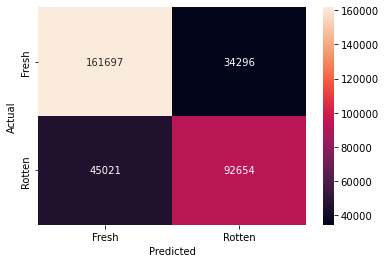

In [96]:
ticklabels = ["Fresh", "Rotten"]
ax = seaborn.heatmap(cm,
                     # label columns and rows
                     xticklabels=ticklabels,
                     yticklabels=ticklabels,
                     # list numbers
                     annot=True,
                     # write numbers out normally
                     fmt='d')
# set axis labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

### Creating your table of contents and sections
Break down your sections using markdown headings of different sizes (greater or fewer #s). Users will have access to a table of contents automatically generated by headings. To get a preview of this on your local machine, install:

`pip install jupyter_contrib_nbextensions`

Then install the javascript and css files using:

`jupyter contrib nbextension install --user`

Reopen Jupyter Notebook to refresh. Then choose **File** > **Open**. Then the "NBExtensions" tab. Unselect "disable configuration for nbextensions..." and then choose "Table of Contents (2)". You may need to reopen or refresh the current notebook. In the header, you will see the toggle button for the table of contents. For more details, see this [video](https://www.youtube.com/watch?v=_3VD289eOtU).

### Markdown cheatsheet

A [quick cheatsheet](https://www.markdownguide.org/cheat-sheet/) for useful markdown in Jupyter. When adding images, please be sure to include an alternative description for accessibility purposes.

### Data/Image/Video hosting

Github is not a good place to store images, data, or other large files for your lesson. Please store them somewhere else (Google Drive, Dropbox, Amazon S3, etc.).

### Creating screenshots

#### Mac
I recommend using command-shift-4 to draw a square around the part of the screen you want to screenshot. I often use [paintbrush](https://paintbrush.sourceforge.io/) for basic editing. For moving images (.gifs), I use command-shift-5 then convert the video using [Gifski](https://github.com/sindresorhus/Gifski). Make sure you use very few frames-per-second because gif file size can get large very quickly.

#### Windows
I recommend capturing a screenshot using the print-screen key on your keyboard, then pasting into Microsoft Paint. At that point, it is easy to crop just the relevant section.

___
[Proceed to next lesson: Course Title 2/3 ->](./lesson-2.ipynb)

# Exercises (Optional)

`If possible, include practice exercises for users to do on their own. These may have clear solutions or be more open-ended.`

# Solutions (Optional)
`Offer some possible solutions for the practice exercises.`


# References (Optional)
No citations required but include this if you have cited academic sources. Use whatever format you like, just be consistent. Markdown footnotes are not well-supported in notebooks.[$^{1}$](#1) I suggest using an anchor link with plain html as shown.[$^{2}$](#2)

1. <a id="1"></a> Here is an anchor link footnote.
2. <a id="2"></a> D'Ignazio, Catherine and Lauren F. Klein. [*Data Feminism*](https://mitpress.mit.edu/books/data-feminism). MIT Press, 2020.